# Spam Classification Under Semi-supervised Settings

This code is partly based on https://www.kaggle.com/kredy10/simple-lstm-for-text-classification

## First things first

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import word_tokenize


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [4]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence # for efficient computation of rnns
# https://simonjisu.github.io/nlp/2018/07/05/packedsequence.html

In [5]:
from time import time
import copy
import random
random.seed(1)

## Settings

In [35]:
VOCAB_SIZE=1000
MAXLEN=150 # maximum sequence length
BATCH_SIZE=64
UPSAMPLE=False
VAT=False

## Data

Download SMS Spam Collection Dataset from https://www.kaggle.com/uciml/sms-spam-collection-dataset

Load the data into Pandas dataframe

In [7]:
df = pd.read_csv('spam.csv', sep=",", encoding="latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Drop the columns that are not required for the neural network.

In [8]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
sents = df["v2"].tolist() # inputs
labels = df["v1"].tolist() # targets

Normalize text

In [10]:
def normalize(sent):
    sent = sent.lower()
    words = word_tokenize(sent)
    return words

sents = [normalize(sent) for sent in sents]

## Let's create train and test sets






First, divide data into training and test sets.

In [11]:
sents_train, sents_test, labels_train, labels_test = train_test_split(sents, labels, test_size=.1, shuffle=True)

Next, further divide training samples into labeled and unlabeled.

In [12]:
sents_train, sents_ul, labels_train, labels_ul = train_test_split(sents_train, labels_train, test_size=.8, shuffle=True)

Let's see how many spams are in the training/unlabeled/test data.

In [13]:
print("There are {} training samples ({} spams, {} hams), \n\
{} unlabeled samples ({} spams, {} hams), \n\
and {} test samples ({} spams, {} hams)".format\
      (len(labels_train), labels_train.count("spam"), labels_train.count("ham"),\
       len(labels_ul), labels_ul.count("spam"), labels_ul.count("ham"),\
       len(labels_test), labels_test.count("spam"), labels_test.count("ham")\
      )
     )

There are 1002 training samples (127 spams, 875 hams), 
4012 unlabeled samples (537 spams, 3475 hams), 
and 558 test samples (83 spams, 475 hams)


## Set Vocabulary

Include the most frequent n words in vocabulary.

In [14]:
from collections import Counter
words = [word for sent in sents_train for word in sent]
word2cnt = Counter(words)
vocab = [w for w, c in word2cnt.most_common(len(word2cnt))]

In [15]:
vocab = ["<PAD>", "<EOS>", "<UNK>"] + vocab
vocab = vocab[:VOCAB_SIZE]

Vocabulary looks like ..

In [16]:
vocab[:10]

['<PAD>', '<EOS>', '<UNK>', '.', 'i', 'to', 'you', ',', '?', 'a']

dictionary

In [17]:
word2idx = {word:idx for idx, word in enumerate(vocab)}
idx2word = {idx:word for idx, word in enumerate(vocab)}

## Encode

### Y or labels

In [18]:
def encode_labels(labels):
    return [1 if l=="spam" else 0 for l in labels ]

In [19]:
_Y_train = encode_labels(labels_train)
_Y_ul = encode_labels(labels_ul) # actually this is not needed.
_Y_test = encode_labels(labels_test)

### X or inputs

In [20]:
def encode_sents(sents):
    X = [] # whole input data encoded
    for sent in sents: 
        sent += ["<EOS>"]
        sent += ["<PAD>"]*MAXLEN 
        x = [word2idx.get(word, 2) for word in sent[:MAXLEN]] # 2:<UNK>
        X.append(x)
    return X

In [21]:
_X_train = encode_sents(sents_train)
_X_ul = encode_sents(sents_ul)
_X_test = encode_sents(sents_test)

### Upsampling

In [22]:
if UPSAMPLE:
    from imblearn.over_sampling import SMOTE
    # https://arxiv.org/pdf/1106.1813.pdf
    
    ros = SMOTE(random_state=0)
    _X_train, _Y_train = ros.fit_resample(_X_train, _Y_train) 

### Convert to tensors

In [23]:
X_train = torch.LongTensor(_X_train)
X_ul = torch.LongTensor(_X_ul)
X_test = torch.LongTensor(_X_test)

Y_train = torch.LongTensor(_Y_train)
Y_ul = torch.LongTensor(_Y_ul)
Y_test = torch.LongTensor(_Y_test)

## Data Loader

train

In [24]:
train_dataset = Data.TensorDataset(X_train, Y_train)
train_loader = Data.DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=4)
print(len(train_loader))

16


test

In [25]:
test_dataset = Data.TensorDataset(X_test, Y_test)
test_loader = Data.DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=4)
print(len(test_loader))

9


## Model

In [26]:
from itertools import chain
def get_freq():
    '''Calculates word frequency i.e. count / total occurrences.
    '''
    global _X_train
    idx2cnt = Counter(chain.from_iterable(_X_train))
    pairs = sorted(idx2cnt.items(), key=lambda x: x[0])
    cnts = [pair[1] for pair in pairs]
    cnts = np.array(cnts)
    cnts[0] = 0 # 0's are excluded as they represent paddings.
    freq = cnts / cnts.sum()
    freq = np.expand_dims(freq, 1).astype('float32')
    return torch.from_numpy(freq)

In [32]:
class Net(nn.Module):
    def __init__(self, embedding_dim=50, hidden_dim1=64, hidden_dim2=256, vocab_size=VOCAB_SIZE):
        '''
        Fix the model architecture and its parameters for this purpose
        '''
        super(Net, self).__init__()
        
        self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim1)
        self.dense = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout = nn.Dropout(.5)
        self.readout = nn.Linear(hidden_dim2, 2)

    def forward(self, x, vat=False, r=0):
        '''x: (batch, maxlen)
        vat: boolean.
        r: pertubation. if 0, it means no pertubation. Otherwise it's in the shape of (batch, maxlen, embedding_dim)
        '''     
        # using pack_padded_sequence
        # https://gist.github.com/Tushar-N/dfca335e370a2bc3bc79876e6270099e
        
        # Get sequence lengths
        seqlens = (x!=0).sum(1) # Recall 0's are paddings. (batch,) 
        
        # Reverse sort
        seqlens_sorted, perm_idx = seqlens.sort(0, descending=True)
        x = x[perm_idx]
        
        # Embedding
        if VAT: # Embeddings are normalized and noted as 's' in the paper.
            def _normalize(emb):
                '''normalizes word embeddings.
                emb: (BATCH, VOCAB_SIZE,, embedding_dim)
                https://github.com/TobiasLee/Text-Classification/blob/master/models/adversarial_abblstm.py#L20-L26
                '''
                freq = get_freq() # (VOCAB_SIZE, 1)
                
                # mean
                mean = torch.sum(freq * emb, 0, keepdim=True) # (1, VOCAB_SIZE,, embedding_dim)
                var = torch.sum(freq * torch.pow(emb - mean, 2.), 0, keepdim=True) # (1, VOCAB_SIZE,, embedding_dim)
                stddev = torch.sqrt(1e-6 + var)
                return (emb - mean) / stddev

            embeddings = self.embed(torch.arange(VOCAB_SIZE)) # (VOCAB_SIZE, embedding_dim)
            normalized_embeddings = _normalize(embeddings)
            self.embed.load_state_dict({'weight': normalized_embeddings})  
            
        x = self.embed(x) # (batch, maxlen, embedding_dim)
        
        self.v = x.clone()
        
        # Optional pertubation
        x += r
        
        # Transpose for inputting RNNs in pytorch.
        x = x.transpose(0, 1) # (maxlen, batch, embedding_dim)
       
        ## Pack
        packed_input = pack_padded_sequence(x, seqlens_sorted)   
        outputs, (h, c) = self.lstm(packed_input) # (maxlen, batch, hidden_dim)
        
        # If you only need the last hidden vectors:
        _, unperm_idx = perm_idx.sort(0) # Restore the order
        last_hidden_states = h[-1][unperm_idx]
        
        # Elif you need the entire outputs
        outputs, _ = pad_packed_sequence(outputs)
        outputs = outputs.transpose(0, 1)
   
        x = F.relu(self.dense(last_hidden_states))
        x = self.dropout(x)
        x = self.readout(x)
        return F.log_softmax(x, dim=1), F.softmax(x, dim=1)
        
        
        
        

## Train & test functions

In [27]:
def vat_loss(model, x, xi=1e-6, eps=1.0, ip=1):
    '''
    https://github.com/lyakaap/VAT-pytorch/blob/master/vat.py
    
    x: unlabeled samples
    xi: small constant for finite difference
    eps: constraint. norm length for (virtual) adversarial training
    ip: iteration times of computing adv noise
    '''
    # get predictions based on normalized v (=s)
    _, preds = model(x, vat=True) # softmax values
    
    # generate pertubation
    d = torch.randn_like(model.v)
    
    def _l2_normalize(d):
        norm = torch.norm(d, dim=(1,2), keepdim=True)
        d /= norm + 1e-8
        return d
    
    # Calc adversarial direction
    for _ in range(ip):
        d.requires_grad_()
        preds_, _ = model(x, vat=True, r=xi*d)  # perturbed preds. logsoftmax
        adv_distance = F.kl_div(preds_, preds) # original preds:perturbed preds (preds || preds_). https://github.com/pytorch/pytorch/issues/7337
        adv_distance.backward(retain_graph=True)
        d = _l2_normalize(d.grad)
        model.zero_grad()
        
    
    # calc LDS (= Local Distributional Smoothness). https://arxiv.org/pdf/1507.00677.pdf
    r_vadv = d * eps # r_v-adv: virtual adversarial perturbation
    preds_, _ = model(x, vat=True, r=r_vadv) # Worstly perturbed predictions. logsoftmax.
    lds = F.kl_div(preds_, preds, reduction='batchmean')
    
    return lds

In [29]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs, _ = model(inputs, vat=VAT) # logsoftmax
        loss = F.nll_loss(outputs, targets)
        
        if VAT:
            # Load a minibatch of unlabeled samples
            rand_batch_idx = random.randint(0, len(X_ul)-BATCH_SIZE*4)
            X_ul_batch = X_ul[rand_batch_idx:rand_batch_idx+BATCH_SIZE*4]      

            # vat_loss
            lds  = vat_loss(model, X_ul_batch)

            # Aggregation
            loss += lds
        
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
    return loss

In [30]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    y_pred, y_true = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs, _ = model(inputs)
            test_loss += F.nll_loss(outputs, targets, reduction='sum').item()  # sum up batch loss
            preds = outputs.max(1, keepdim=False)[1]  # get the index of the max log-probability. (batch,)
            y_pred.extend(preds.tolist())
            y_true.extend(targets.tolist())           

    test_loss /= len(test_loader.dataset)
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print('\nTest set: tp %d, fp %d, tn %d, fn %d\nPrecision: %0.2f, Recall: %0.2f, F1_score: %0.2f\n' %(
        tp, fp, tn, fn,
        precision, recall, f1score))
    
    return precision, f1score

## Main

In [36]:
start = time()
model = Net()
optimizer = optim.RMSprop(model.parameters(), lr=.001)

losses, precisions, f1scores = [], [], []
for epoch in range(1, 10+1):
    loss = train(model, train_loader, optimizer, epoch)
    precision, f1score = test(model, test_loader)
    
    losses.append(loss)
    precisions.append(precision)
    f1scores.append(f1score)

print("%d seconds have passed" % (time()-start))
print("Best precision = %.02f" %(max(precisions)))
print("Best f1 score = %.02f" %(max(f1scores)))

Train Epoch: 1 [0/1002 (0%)]	Loss: 0.646478
Train Epoch: 1 [640/1002 (62%)]	Loss: 0.358085

Test set: tp 6, fp 2, tn 473, fn 77
Precision: 0.75, Recall: 0.07, F1_score: 0.13

Train Epoch: 2 [0/1002 (0%)]	Loss: 0.311599
Train Epoch: 2 [640/1002 (62%)]	Loss: 0.251848

Test set: tp 80, fp 45, tn 430, fn 3
Precision: 0.64, Recall: 0.96, F1_score: 0.77

Train Epoch: 3 [0/1002 (0%)]	Loss: 0.110984
Train Epoch: 3 [640/1002 (62%)]	Loss: 0.237412

Test set: tp 17, fp 0, tn 475, fn 66
Precision: 1.00, Recall: 0.20, F1_score: 0.34

Train Epoch: 4 [0/1002 (0%)]	Loss: 0.193263
Train Epoch: 4 [640/1002 (62%)]	Loss: 0.105504

Test set: tp 75, fp 11, tn 464, fn 8
Precision: 0.87, Recall: 0.90, F1_score: 0.89

Train Epoch: 5 [0/1002 (0%)]	Loss: 0.076566
Train Epoch: 5 [640/1002 (62%)]	Loss: 0.255215

Test set: tp 74, fp 11, tn 464, fn 9
Precision: 0.87, Recall: 0.89, F1_score: 0.88

Train Epoch: 6 [0/1002 (0%)]	Loss: 0.056747
Train Epoch: 6 [640/1002 (62%)]	Loss: 0.004567

Test set: tp 79, fp 24, tn 45

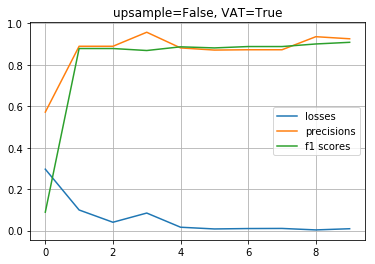

In [34]:
# Plot
plt.title("upsample={}, VAT={}".format(UPSAMPLE, VAT))
plt.plot(losses, label="losses")
plt.plot(precisions, label="precisions")
plt.plot(f1scores, label="f1 scores")
plt.grid()
plt.legend()
plt.show()

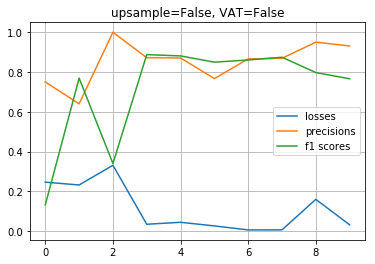

In [37]:
# Plot
plt.title("upsample={}, VAT={}".format(UPSAMPLE, VAT))
plt.plot(losses, label="losses")
plt.plot(precisions, label="precisions")
plt.plot(f1scores, label="f1 scores")
plt.grid()
plt.legend()
plt.show()